# ***Whispers of Deception: DistilBERT’s Sleek Hunt for Hidden Lies***
## Overview of Model Development Steps:
- Installed and imported essential libraries and tools, including Hugging Face’s Transformers.

- Loaded and preprocessed the dataset, labeling each entry as True or False.

- Applied text augmentation techniques to diversify and strengthen the training set.

- Tokenized the text using the DistilBERT tokenizer for compatibility and efficiency.

- Built and fine-tuned a DistilBERT sequence classification model, incorporating class weighting to handle data imbalance.
---



In [1]:
# Install the required packages and libraries
!pip install transformers torch pandas numpy matplotlib seaborn scikit-learn
!pip install nlpaug

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, DistilBertConfig, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
import nlpaug.augmenter.word as naw
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, auc


In [3]:
# Check device
print("GPU is available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

GPU is available: True
Device being used: cuda


In [4]:
# Load and preprocess data
df = pd.read_csv('/content/politifact (1).csv')
df['statement'] = df['statement'].str.replace(r'[^\w\s]', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()

# Keep only binary classes: True/Mostly True vs. the rest
df = df[df['veracity'].isin(['True', 'Mostly True', 'Pants on Fire!', 'False', 'Mostly False'])]
df['binary_label'] = df['veracity'].apply(lambda label: 1 if label in ['True', 'Mostly True'] else 0)

# Split data
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Data augmentation
try:
    aug_synonym = naw.SynonymAug(aug_p=0.5)
    aug_random = naw.RandomWordAug(action="swap", aug_p=0.3)
    train_df['statement_synonym'] = train_df['statement'].apply(lambda x: aug_synonym.augment(x)[0])
    train_df['statement_random'] = train_df['statement'].apply(lambda x: aug_random.augment(x)[0])
    train_df = pd.concat([
        train_df[['statement', 'binary_label']],
        train_df[['statement_synonym', 'binary_label']].rename(columns={'statement_synonym': 'statement'}),
        train_df[['statement_random', 'binary_label']].rename(columns={'statement_random': 'statement'})
    ])
    print("Data augmentation applied (synonym + random word swap).")
except Exception as e:
    print(f"Warning: Augmentation failed: {e}. Proceeding without augmentation.")

# Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


<ipython-input-4-91af3b4b4d44>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['binary_label'] = df['veracity'].apply(lambda label: 1 if label in ['True', 'Mostly True'] else 0)
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


**********************************************************************
  Resource averaged_perceptron_tagger_eng not found.
  Please use the NLTK Downloader to obtain the resource:

  >>> import nltk
  >>> nltk.download('averaged_perceptron_tagger_eng')
  
  For more information see: https://www.nltk.org/data.html

  Attempted to load taggers/averaged_perceptron_tagger_eng/

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************
. Proceeding without augmentation.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

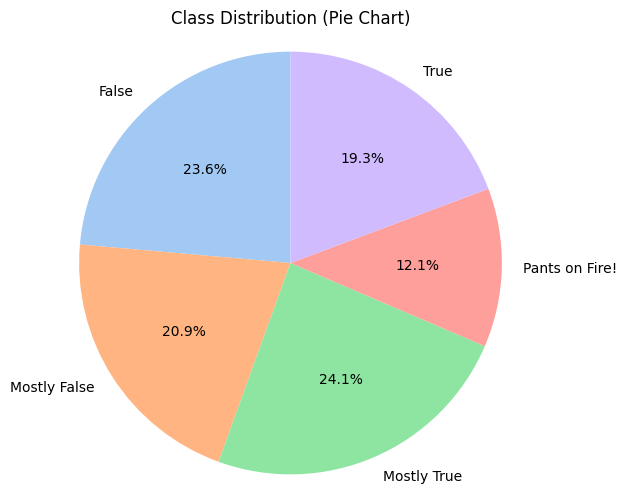


Sample Statements from Each Class:

Class False Samples:
['The Florida House is holding the FINAL public hearing of a controversial education bill in the middle of spring breakwhen they hope teachers are not watching or listening'
 'Oprah tells Fox News host all white people have to die'
 'George Allen cast the deciding vote for the 2003 Bush tax cuts']

Class Mostly False Samples:
['Since being elected Tom Barrett has dumped 82 billion gallons of raw sewage into Lake Michigan'
 'We have asked public employees to pay 10 percent of the costs of their guaranteed pension and 15 percent of the cost of their health care The leadership of those public employees unions dont want to pay anything'
 'There is majority support for the Democrats health care plans']

Class Mostly True Samples:
['Says Hillary Clinton supported North American Free Trade Agreement and she supported Chinas entrance into the World Trade Organization She supported the jobkilling trade deal with South Korea She supported

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count class distribution
label_counts = df['veracity'].value_counts().sort_index()

# Pie chart
plt.figure(figsize=(6,6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("pastel"))
plt.title("Class Distribution (Pie Chart)")
plt.axis('equal')
plt.show()


label_counts = df['veracity'].value_counts().sort_index()

print("\nSample Statements from Each Class:")
for label in label_counts.index:
    print(f"\nClass {label} Samples:")
    print(df[df['veracity'] == label]['statement'].sample(3, random_state=42).values)



In [6]:
# Dataset class
class TruthDetectionDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len=256):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = str(self.data.iloc[index]['statement'])
        label = int(self.data.iloc[index]['binary_label'])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Parameters
MAX_LEN = 128
LEARNING_RATE = 1e-4
BATCH_SIZE = 32
DROPOUT_RATE = 0.3
EPOCHS = 3
PATIENCE = 2



In [7]:
print("Unique labels:", df['veracity'].unique())
print("\nLabel counts:")
print(df['veracity'].value_counts())

Unique labels: ['Pants on Fire!' 'Mostly True' 'False' 'True' 'Mostly False']

Label counts:
veracity
Mostly True       2695
False             2641
Mostly False      2335
True              2158
Pants on Fire!    1359
Name: count, dtype: int64


In [8]:
# Create datasets and loaders
train_dataset = TruthDetectionDataset(train_df, tokenizer, MAX_LEN)
val_dataset = TruthDetectionDataset(val_df, tokenizer, MAX_LEN)
test_dataset = TruthDetectionDataset(test_df, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [9]:
# Initialize DistilBERT model with binary classification config
config = DistilBertConfig.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2,  # binary classification
    dropout=DROPOUT_RATE,
    seq_classif_dropout=0.3
)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    config=config
).to(device)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.array([0, 1]), y=df['binary_label'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights).to(device)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:

# Training function
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    losses = []
    correct_predictions = 0

    for batch in data_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / len(data_loader.dataset), np.mean(losses)

# Evaluation function
def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    correct_predictions = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            probs = torch.softmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    return {
        'accuracy': correct_predictions.double() / len(data_loader.dataset),
        'loss': np.mean(losses),
        'preds': np.array(all_preds),
        'labels': np.array(all_labels),
        'probs': np.array(all_probs)
    }


In [11]:

# Training loop
best_val_loss = float('inf')
best_accuracy = 0
patience_counter = 0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    val_results = eval_model(model, val_loader, loss_fn, device)
    val_acc, val_loss = val_results['accuracy'], val_results['loss']
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f'Train loss: {train_loss:.4f} | accuracy: {train_acc:.4f}')
    print(f'Val loss: {val_loss:.4f} | accuracy: {val_acc:.4f}\n')

    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), 'best_model_state.bin')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print("Early stopping triggered")
            break

# Load best model
model.load_state_dict(torch.load('best_model_state.bin'))

# Evaluate on test set
test_results = eval_model(model, test_loader, loss_fn, device)

Epoch 1/3
----------
Train loss: 0.6632 | accuracy: 0.6145
Val loss: 0.6481 | accuracy: 0.6460

Epoch 2/3
----------
Train loss: 0.6178 | accuracy: 0.6667
Val loss: 0.6261 | accuracy: 0.6520

Epoch 3/3
----------
Train loss: 0.5458 | accuracy: 0.7346
Val loss: 0.6383 | accuracy: 0.6621



In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Metrics function for binary classification
def calculate_metrics(labels, preds, probs):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

    metrics = {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds),
        'f1': f1_score(labels, preds),
        'roc_auc': roc_auc_score(labels, probs[:, 1])
    }

    fpr, tpr, _ = roc_curve(labels, probs[:, 1])

    return metrics, fpr, tpr

# Calculate metrics
binary_metrics, fpr, tpr = calculate_metrics(
    test_results['labels'],
    test_results['preds'],
    test_results['probs']
)

# print metrics
print("\nTest Set Metrics:")
print(f"Accuracy: {binary_metrics['accuracy']:.4f}")
print(f"Precision: {binary_metrics['precision']:.4f}")
print(f"Recall: {binary_metrics['recall']:.4f}")
print(f"F1 Score: {binary_metrics['f1']:.4f}")
print(f"ROC AUC: {binary_metrics['roc_auc']:.4f}")




Test Set Metrics:
Accuracy: 0.6516
Precision: 0.6000
Recall: 0.5926
F1 Score: 0.5963
ROC AUC: 0.7127


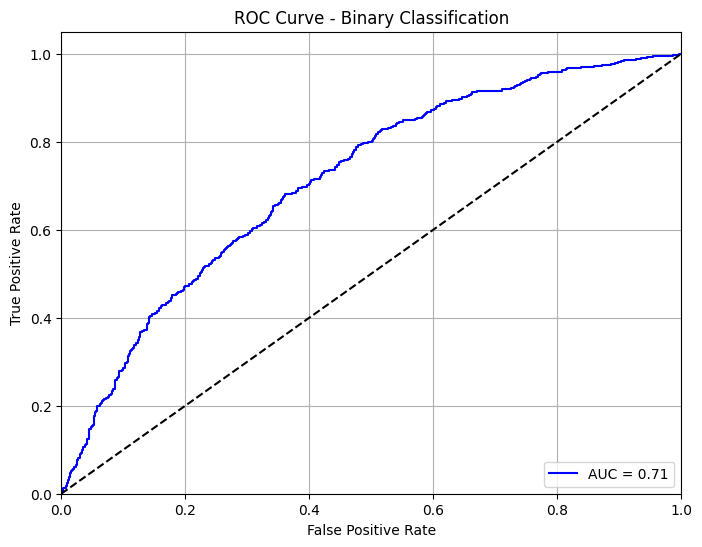

In [13]:
# ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {binary_metrics["roc_auc"]:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Binary Classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()



<Figure size 600x600 with 0 Axes>

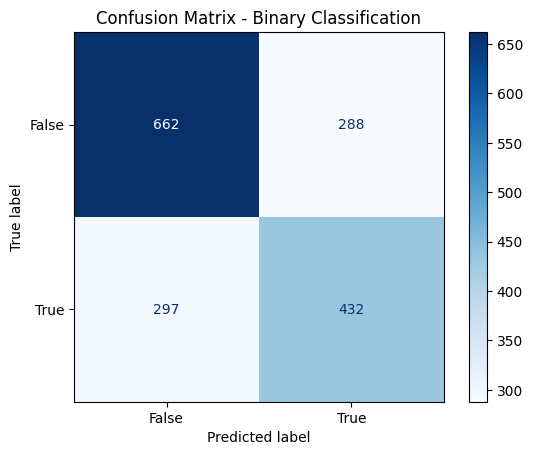

In [14]:
# Confusion Matrix
cm = confusion_matrix(test_results['labels'], test_results['preds'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False", "True"])

plt.figure(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix - Binary Classification')
plt.grid(False)
plt.show()
